In [2]:
import pickle
import pandas as pd
import numpy as np
from psm_causal_effects import psm_causal_effects
from extract_remove_nans import extract_remove_nans

# read data
with open('data.dat','rb') as f:
    data, subjects = pickle.load(f)
f.close()

# read assessments
with open('assessment.dat', 'rb') as f:
    ass = pickle.load(f)
f.close()

# defining groups based on screening data (week 0)
groups = ['Depressed & Anxious','Anxious only','Depressed only','Control']
indg = [np.array([],dtype=int) for i in range(4)]
for i in range(len(data)):
    ind = np.where(subjects[i]==ass['ID'])[0][0]
    if ind:
        if ass.loc[ind,'PHQ9 W0']>=10 and ass.loc[ind,'GAD7 W0']>=10:
            indg[0] = np.append(indg[0], i)
        elif ass.loc[ind,'PHQ9 W0']<10 and ass.loc[ind, 'GAD7 W0']>=10:
            indg[1] = np.append(indg[1], i)
        elif ass.loc[ind, 'PHQ9 W0']>=10 and ass.loc[ind,'GAD7 W0']<10:
            indg[2] = np.append(indg[2], i)
        elif ass.loc[ind, 'PHQ9 W0']<10 and ass.loc[ind,'GAD7 W0']<10:
            indg[3] = np.append(indg[3], i)
        else:
            print('ERROR')

n_boot = 100
scorefunction = 'replacement'
output = 'difference'
var_threshold = 0.5

es_m2s_mean = np.zeros([n_boot,4])
es_s2m_mean = np.zeros([n_boot,4])
es_s2m_um_mean = np.zeros([n_boot,4])
es_m2s_um_mean = np.zeros([n_boot,4])
    
for g in range(len(groups)):
    
    print(groups[g]+':')

    for k in range(n_boot):

        print (k),

        inds = np.random.choice(indg[g], size=indg[g].size, replace=True)

        es_s2m = np.zeros([indg[g].size,1])
        es_m2s = np.zeros([indg[g].size,1])
        es_s2m_um = np.zeros([indg[g].size,1])
        es_m2s_um = np.zeros([indg[g].size,1])

        for (c,i) in enumerate(inds):

            if np.nanstd(data[i]['mood'])<var_threshold or np.nanstd(data[i]['quality'])<var_threshold:
                print('skipping subject '+str(i)+' due to low variance in mood or sleep quality.')
                es_m2s_um[c] = np.nan
                es_m2s[c] = np.nan
                es_s2m_um[c] = np.nan
                es_s2m[c] = np.nan
                continue

            # mood on sleep - lag 0 - unmatched
            treatment = 'mood_prev'
            outcome = 'quality'
            data_s = extract_remove_nans(data[i], [treatment]+[outcome])
            es_m2s_um[c] = psm_causal_effects(treatment=data_s[treatment], outcome=data_s[outcome], confound=[], scorefun='unmatched', output=output)

            # mood on sleep - lag 1
            confound = ['dow', 'mean_temp_prev2', 'clear_prev2', 'act_prev2','daytype','stress_prev2','energy_prev2','focus_prev2','mood_prev2','quality_prev']
            data_s = extract_remove_nans(data[i], [treatment]+[outcome]+confound)
            es_m2s[c] = psm_causal_effects(treatment=data_s[treatment], outcome=data_s[outcome], confound=data_s[confound], scorefun=scorefunction, output=output)

            ################ sleep on mood

            # sleep on mood - lag 0 - unmatched
            treatment = 'quality'
            outcome = 'mood'
            data_s = extract_remove_nans(data[i], [treatment]+[outcome])
            es_s2m_um[c] = psm_causal_effects(treatment=data_s[treatment], outcome=data_s[outcome], confound=[], scorefun='unmatched', output=output)

            # sleep on mood - lag 1
            confound = ['dow', 'mean_temp_prev', 'clear_prev','act_prev','daytype','stress_prev','energy_prev','focus_prev','mood_prev','quality_prev']
            data_s = extract_remove_nans(data[i], [treatment]+[outcome]+confound)
            es_s2m[c] = psm_causal_effects(treatment=data_s[treatment], outcome=data_s[outcome], confound=data_s[confound], scorefun=scorefunction, output=output)

        es_m2s_mean[k,g] = np.nanmean(es_m2s, axis=0)
        es_s2m_mean[k,g] = np.nanmean(es_s2m, axis=0)
        es_m2s_um_mean[k,g] = np.nanmean(es_m2s_um, axis=0)
        es_s2m_um_mean[k,g] = np.nanmean(es_s2m_um, axis=0)



depressed&anxious:
0
skipping subject 7 due to low variance in mood or sleep quality.
1
skipping subject 33 due to low variance in mood or sleep quality.
skipping subject 7 due to low variance in mood or sleep quality.
skipping subject 33 due to low variance in mood or sleep quality.
skipping subject 33 due to low variance in mood or sleep quality.
2
skipping subject 7 due to low variance in mood or sleep quality.
skipping subject 7 due to low variance in mood or sleep quality.
3
skipping subject 33 due to low variance in mood or sleep quality.
skipping subject 7 due to low variance in mood or sleep quality.
skipping subject 33 due to low variance in mood or sleep quality.
skipping subject 33 due to low variance in mood or sleep quality.
4
skipping subject 7 due to low variance in mood or sleep quality.
5
skipping subject 7 due to low variance in mood or sleep quality.
skipping subject 7 due to low variance in mood or sleep quality.
skipping subject 7 due to low variance in mood or sle

skipping subject 7 due to low variance in mood or sleep quality.
60
skipping subject 7 due to low variance in mood or sleep quality.
skipping subject 7 due to low variance in mood or sleep quality.
61
skipping subject 7 due to low variance in mood or sleep quality.
skipping subject 33 due to low variance in mood or sleep quality.
62
skipping subject 33 due to low variance in mood or sleep quality.
skipping subject 33 due to low variance in mood or sleep quality.
skipping subject 7 due to low variance in mood or sleep quality.
63
skipping subject 33 due to low variance in mood or sleep quality.
skipping subject 33 due to low variance in mood or sleep quality.
64
65
skipping subject 33 due to low variance in mood or sleep quality.
66
skipping subject 7 due to low variance in mood or sleep quality.
skipping subject 7 due to low variance in mood or sleep quality.
67
68
skipping subject 7 due to low variance in mood or sleep quality.
skipping subject 33 due to low variance in mood or sleep 

skipping subject 111 due to low variance in mood or sleep quality.
skipping subject 111 due to low variance in mood or sleep quality.
39
skipping subject 111 due to low variance in mood or sleep quality.
skipping subject 111 due to low variance in mood or sleep quality.
40
41
42
skipping subject 111 due to low variance in mood or sleep quality.
skipping subject 111 due to low variance in mood or sleep quality.
43
44
skipping subject 111 due to low variance in mood or sleep quality.
skipping subject 111 due to low variance in mood or sleep quality.
45
46
skipping subject 111 due to low variance in mood or sleep quality.
47
48
skipping subject 111 due to low variance in mood or sleep quality.
49
skipping subject 111 due to low variance in mood or sleep quality.
skipping subject 111 due to low variance in mood or sleep quality.
50
skipping subject 111 due to low variance in mood or sleep quality.
51
skipping subject 111 due to low variance in mood or sleep quality.
52
53
54
skipping subje

35
skipping subject 91 due to low variance in mood or sleep quality.
skipping subject 91 due to low variance in mood or sleep quality.
skipping subject 136 due to low variance in mood or sleep quality.
skipping subject 91 due to low variance in mood or sleep quality.
36
skipping subject 136 due to low variance in mood or sleep quality.
skipping subject 136 due to low variance in mood or sleep quality.
skipping subject 91 due to low variance in mood or sleep quality.
skipping subject 136 due to low variance in mood or sleep quality.
37
38
skipping subject 91 due to low variance in mood or sleep quality.
skipping subject 91 due to low variance in mood or sleep quality.
skipping subject 91 due to low variance in mood or sleep quality.
39
skipping subject 91 due to low variance in mood or sleep quality.
skipping subject 91 due to low variance in mood or sleep quality.
skipping subject 136 due to low variance in mood or sleep quality.
skipping subject 136 due to low variance in mood or slee

skipping subject 136 due to low variance in mood or sleep quality.
88
skipping subject 91 due to low variance in mood or sleep quality.
skipping subject 136 due to low variance in mood or sleep quality.
89
skipping subject 136 due to low variance in mood or sleep quality.
90
skipping subject 136 due to low variance in mood or sleep quality.
skipping subject 91 due to low variance in mood or sleep quality.
91
skipping subject 136 due to low variance in mood or sleep quality.
skipping subject 91 due to low variance in mood or sleep quality.
skipping subject 136 due to low variance in mood or sleep quality.
92
skipping subject 91 due to low variance in mood or sleep quality.
93
skipping subject 91 due to low variance in mood or sleep quality.
94
skipping subject 91 due to low variance in mood or sleep quality.
skipping subject 91 due to low variance in mood or sleep quality.
95
skipping subject 136 due to low variance in mood or sleep quality.
skipping subject 136 due to low variance in m

skipping subject 69 due to low variance in mood or sleep quality.
skipping subject 67 due to low variance in mood or sleep quality.
skipping subject 40 due to low variance in mood or sleep quality.
skipping subject 119 due to low variance in mood or sleep quality.
skipping subject 96 due to low variance in mood or sleep quality.
6
skipping subject 35 due to low variance in mood or sleep quality.
skipping subject 69 due to low variance in mood or sleep quality.
skipping subject 96 due to low variance in mood or sleep quality.
skipping subject 27 due to low variance in mood or sleep quality.
skipping subject 96 due to low variance in mood or sleep quality.
skipping subject 151 due to low variance in mood or sleep quality.
skipping subject 35 due to low variance in mood or sleep quality.
skipping subject 3 due to low variance in mood or sleep quality.
skipping subject 170 due to low variance in mood or sleep quality.
skipping subject 67 due to low variance in mood or sleep quality.
skippi

skipping subject 35 due to low variance in mood or sleep quality.
skipping subject 119 due to low variance in mood or sleep quality.
12
skipping subject 151 due to low variance in mood or sleep quality.
skipping subject 170 due to low variance in mood or sleep quality.
skipping subject 69 due to low variance in mood or sleep quality.
skipping subject 113 due to low variance in mood or sleep quality.
skipping subject 67 due to low variance in mood or sleep quality.
skipping subject 119 due to low variance in mood or sleep quality.
skipping subject 96 due to low variance in mood or sleep quality.
skipping subject 35 due to low variance in mood or sleep quality.
skipping subject 96 due to low variance in mood or sleep quality.
skipping subject 61 due to low variance in mood or sleep quality.
skipping subject 27 due to low variance in mood or sleep quality.
skipping subject 32 due to low variance in mood or sleep quality.
skipping subject 150 due to low variance in mood or sleep quality.
1

skipping subject 199 due to low variance in mood or sleep quality.
skipping subject 27 due to low variance in mood or sleep quality.
skipping subject 40 due to low variance in mood or sleep quality.
skipping subject 32 due to low variance in mood or sleep quality.
skipping subject 32 due to low variance in mood or sleep quality.
skipping subject 12 due to low variance in mood or sleep quality.
skipping subject 199 due to low variance in mood or sleep quality.
skipping subject 96 due to low variance in mood or sleep quality.
skipping subject 170 due to low variance in mood or sleep quality.
skipping subject 113 due to low variance in mood or sleep quality.
skipping subject 40 due to low variance in mood or sleep quality.
skipping subject 199 due to low variance in mood or sleep quality.
skipping subject 67 due to low variance in mood or sleep quality.
19
skipping subject 35 due to low variance in mood or sleep quality.
skipping subject 35 due to low variance in mood or sleep quality.
sk

skipping subject 151 due to low variance in mood or sleep quality.
skipping subject 150 due to low variance in mood or sleep quality.
skipping subject 150 due to low variance in mood or sleep quality.
skipping subject 12 due to low variance in mood or sleep quality.
skipping subject 96 due to low variance in mood or sleep quality.
26
skipping subject 113 due to low variance in mood or sleep quality.
skipping subject 67 due to low variance in mood or sleep quality.
skipping subject 150 due to low variance in mood or sleep quality.
skipping subject 203 due to low variance in mood or sleep quality.
skipping subject 32 due to low variance in mood or sleep quality.
skipping subject 119 due to low variance in mood or sleep quality.
skipping subject 64 due to low variance in mood or sleep quality.
skipping subject 199 due to low variance in mood or sleep quality.
skipping subject 96 due to low variance in mood or sleep quality.
skipping subject 203 due to low variance in mood or sleep quality

skipping subject 3 due to low variance in mood or sleep quality.
skipping subject 40 due to low variance in mood or sleep quality.
skipping subject 96 due to low variance in mood or sleep quality.
33
skipping subject 32 due to low variance in mood or sleep quality.
skipping subject 67 due to low variance in mood or sleep quality.
skipping subject 96 due to low variance in mood or sleep quality.
skipping subject 69 due to low variance in mood or sleep quality.
skipping subject 61 due to low variance in mood or sleep quality.
skipping subject 67 due to low variance in mood or sleep quality.
skipping subject 96 due to low variance in mood or sleep quality.
skipping subject 203 due to low variance in mood or sleep quality.
skipping subject 151 due to low variance in mood or sleep quality.
skipping subject 150 due to low variance in mood or sleep quality.
skipping subject 35 due to low variance in mood or sleep quality.
skipping subject 150 due to low variance in mood or sleep quality.
skip

skipping subject 151 due to low variance in mood or sleep quality.
skipping subject 69 due to low variance in mood or sleep quality.
skipping subject 27 due to low variance in mood or sleep quality.
skipping subject 96 due to low variance in mood or sleep quality.
skipping subject 170 due to low variance in mood or sleep quality.
41
skipping subject 61 due to low variance in mood or sleep quality.
skipping subject 199 due to low variance in mood or sleep quality.
skipping subject 35 due to low variance in mood or sleep quality.
skipping subject 113 due to low variance in mood or sleep quality.
skipping subject 96 due to low variance in mood or sleep quality.
skipping subject 12 due to low variance in mood or sleep quality.
skipping subject 151 due to low variance in mood or sleep quality.
skipping subject 150 due to low variance in mood or sleep quality.
skipping subject 150 due to low variance in mood or sleep quality.
skipping subject 40 due to low variance in mood or sleep quality.


skipping subject 3 due to low variance in mood or sleep quality.
skipping subject 151 due to low variance in mood or sleep quality.
48
skipping subject 96 due to low variance in mood or sleep quality.
skipping subject 151 due to low variance in mood or sleep quality.
skipping subject 35 due to low variance in mood or sleep quality.
skipping subject 150 due to low variance in mood or sleep quality.
skipping subject 113 due to low variance in mood or sleep quality.
skipping subject 69 due to low variance in mood or sleep quality.
skipping subject 199 due to low variance in mood or sleep quality.
skipping subject 27 due to low variance in mood or sleep quality.
skipping subject 61 due to low variance in mood or sleep quality.
skipping subject 12 due to low variance in mood or sleep quality.
skipping subject 151 due to low variance in mood or sleep quality.
skipping subject 40 due to low variance in mood or sleep quality.
skipping subject 67 due to low variance in mood or sleep quality.
sk

skipping subject 61 due to low variance in mood or sleep quality.
skipping subject 151 due to low variance in mood or sleep quality.
skipping subject 40 due to low variance in mood or sleep quality.
skipping subject 96 due to low variance in mood or sleep quality.
skipping subject 40 due to low variance in mood or sleep quality.
skipping subject 27 due to low variance in mood or sleep quality.
55
skipping subject 119 due to low variance in mood or sleep quality.
skipping subject 69 due to low variance in mood or sleep quality.
skipping subject 199 due to low variance in mood or sleep quality.
skipping subject 64 due to low variance in mood or sleep quality.
skipping subject 61 due to low variance in mood or sleep quality.
skipping subject 3 due to low variance in mood or sleep quality.
skipping subject 119 due to low variance in mood or sleep quality.
skipping subject 40 due to low variance in mood or sleep quality.
skipping subject 40 due to low variance in mood or sleep quality.
skip

skipping subject 64 due to low variance in mood or sleep quality.
skipping subject 203 due to low variance in mood or sleep quality.
skipping subject 203 due to low variance in mood or sleep quality.
skipping subject 61 due to low variance in mood or sleep quality.
skipping subject 199 due to low variance in mood or sleep quality.
skipping subject 151 due to low variance in mood or sleep quality.
skipping subject 69 due to low variance in mood or sleep quality.
skipping subject 150 due to low variance in mood or sleep quality.
skipping subject 69 due to low variance in mood or sleep quality.
skipping subject 27 due to low variance in mood or sleep quality.
skipping subject 12 due to low variance in mood or sleep quality.
skipping subject 3 due to low variance in mood or sleep quality.
skipping subject 119 due to low variance in mood or sleep quality.
62
skipping subject 32 due to low variance in mood or sleep quality.
skipping subject 64 due to low variance in mood or sleep quality.
sk

69
skipping subject 67 due to low variance in mood or sleep quality.
skipping subject 27 due to low variance in mood or sleep quality.
skipping subject 113 due to low variance in mood or sleep quality.
skipping subject 67 due to low variance in mood or sleep quality.
skipping subject 67 due to low variance in mood or sleep quality.
skipping subject 40 due to low variance in mood or sleep quality.
skipping subject 61 due to low variance in mood or sleep quality.
skipping subject 170 due to low variance in mood or sleep quality.
skipping subject 64 due to low variance in mood or sleep quality.
skipping subject 61 due to low variance in mood or sleep quality.
skipping subject 96 due to low variance in mood or sleep quality.
skipping subject 151 due to low variance in mood or sleep quality.
skipping subject 61 due to low variance in mood or sleep quality.
skipping subject 35 due to low variance in mood or sleep quality.
skipping subject 203 due to low variance in mood or sleep quality.
ski

skipping subject 69 due to low variance in mood or sleep quality.
skipping subject 27 due to low variance in mood or sleep quality.
skipping subject 64 due to low variance in mood or sleep quality.
skipping subject 61 due to low variance in mood or sleep quality.
skipping subject 61 due to low variance in mood or sleep quality.
skipping subject 3 due to low variance in mood or sleep quality.
skipping subject 69 due to low variance in mood or sleep quality.
skipping subject 199 due to low variance in mood or sleep quality.
skipping subject 32 due to low variance in mood or sleep quality.
skipping subject 170 due to low variance in mood or sleep quality.
skipping subject 199 due to low variance in mood or sleep quality.
skipping subject 151 due to low variance in mood or sleep quality.
skipping subject 61 due to low variance in mood or sleep quality.
skipping subject 69 due to low variance in mood or sleep quality.
skipping subject 35 due to low variance in mood or sleep quality.
skippin

skipping subject 64 due to low variance in mood or sleep quality.
84
skipping subject 113 due to low variance in mood or sleep quality.
skipping subject 40 due to low variance in mood or sleep quality.
skipping subject 61 due to low variance in mood or sleep quality.
skipping subject 32 due to low variance in mood or sleep quality.
skipping subject 27 due to low variance in mood or sleep quality.
skipping subject 3 due to low variance in mood or sleep quality.
skipping subject 151 due to low variance in mood or sleep quality.
skipping subject 96 due to low variance in mood or sleep quality.
skipping subject 67 due to low variance in mood or sleep quality.
skipping subject 12 due to low variance in mood or sleep quality.
skipping subject 170 due to low variance in mood or sleep quality.
skipping subject 12 due to low variance in mood or sleep quality.
skipping subject 64 due to low variance in mood or sleep quality.
skipping subject 12 due to low variance in mood or sleep quality.
skipp

skipping subject 12 due to low variance in mood or sleep quality.
skipping subject 151 due to low variance in mood or sleep quality.
skipping subject 35 due to low variance in mood or sleep quality.
skipping subject 96 due to low variance in mood or sleep quality.
skipping subject 203 due to low variance in mood or sleep quality.
92
skipping subject 199 due to low variance in mood or sleep quality.
skipping subject 203 due to low variance in mood or sleep quality.
skipping subject 27 due to low variance in mood or sleep quality.
skipping subject 113 due to low variance in mood or sleep quality.
skipping subject 199 due to low variance in mood or sleep quality.
skipping subject 151 due to low variance in mood or sleep quality.
skipping subject 69 due to low variance in mood or sleep quality.
skipping subject 3 due to low variance in mood or sleep quality.
skipping subject 27 due to low variance in mood or sleep quality.
skipping subject 199 due to low variance in mood or sleep quality.


skipping subject 40 due to low variance in mood or sleep quality.
skipping subject 67 due to low variance in mood or sleep quality.
skipping subject 27 due to low variance in mood or sleep quality.
skipping subject 32 due to low variance in mood or sleep quality.
skipping subject 40 due to low variance in mood or sleep quality.
skipping subject 96 due to low variance in mood or sleep quality.
skipping subject 119 due to low variance in mood or sleep quality.
99
skipping subject 61 due to low variance in mood or sleep quality.
skipping subject 151 due to low variance in mood or sleep quality.
skipping subject 203 due to low variance in mood or sleep quality.
skipping subject 12 due to low variance in mood or sleep quality.
skipping subject 12 due to low variance in mood or sleep quality.
skipping subject 150 due to low variance in mood or sleep quality.
skipping subject 199 due to low variance in mood or sleep quality.
skipping subject 96 due to low variance in mood or sleep quality.
sk

## Save Results

In [19]:
df = pd.DataFrame(es_s2m_um_mean)
df.to_csv('results.csv')

## Group Difference

In [34]:
from scipy.stats import f_oneway
from scipy.stats import ttest_ind

#anova
# f,p = f_oneway(es_m2s_um_mean[:,0],es_m2s_um_mean[:,1],es_m2s_um_mean[:,2],es_m2s_um_mean[:,3])
# print('F,P = ',f,p)
# f,p = f_oneway(es_s2m_um_mean[:,0],es_s2m_um_mean[:,1],es_s2m_um_mean[:,2],es_s2m_um_mean[:,3])
# print('F,P = ',f,p)
# f,p = f_oneway(es_m2s_mean[:,0],es_m2s_mean[:,1],es_m2s_mean[:,2],es_m2s_mean[:,3])
# print('F,P = ',f,p)
# f,p = f_oneway(es_s2m_mean[:,0],es_s2m_mean[:,1],es_s2m_mean[:,2],es_s2m_mean[:,3])
# print('F,P = ',f,p)
# print()

#t-test
t,p = ttest_ind(es_m2s_um_mean[:100,3], es_m2s_um_mean[:100,2], equal_var=False, axis=0)
print('T,P = ',t,p)
t,p = ttest_ind(es_m2s_um_mean[:100,3], es_m2s_um_mean[:100,1], equal_var=False, axis=0)
print('T,P = ',t,p)
t,p = ttest_ind(es_m2s_um_mean[:100,3], es_m2s_um_mean[:100,0], equal_var=False, axis=0)
print('T,P = ',t,p)

print()
t,p = ttest_ind(es_s2m_um_mean[:100,3], es_s2m_um_mean[:100,2], equal_var=True, axis=0)
print('T,P = ',t,p)
t,p = ttest_ind(es_s2m_um_mean[:100,3], es_s2m_um_mean[:100,1], equal_var=True, axis=0)
print('T,P = ',t,p)
t,p = ttest_ind(es_s2m_um_mean[:100,3], es_s2m_um_mean[:100,0], equal_var=True, axis=0)
print('T,P = ',t,p)

print()
t,p = ttest_ind(es_m2s_mean[:100,3], es_m2s_mean[:100,2], equal_var=False, axis=0)
print('T,P = ',t,p)
t,p = ttest_ind(es_m2s_mean[:100,3], es_m2s_mean[:100,1], equal_var=False, axis=0)
print('T,P = ',t,p)
t,p = ttest_ind(es_m2s_mean[:100,3], es_m2s_mean[:100,0], equal_var=False, axis=0)
print('T,P = ',t,p)

print()
t,p = ttest_ind(es_s2m_mean[:100,3], es_s2m_mean[:100,2], equal_var=True, axis=0)
print('T,P = ',t,p)
t,p = ttest_ind(es_s2m_mean[:100,3], es_s2m_mean[:100,1], equal_var=True, axis=0)
print('T,P = ',t,p)
t,p = ttest_ind(es_s2m_mean[:100,3], es_s2m_mean[:100,0], equal_var=True, axis=0)
print('T,P = ',t,p)


T,P =  -9.11962304337 2.76737433081e-16
T,P =  -18.4638455104 7.50540748974e-45
T,P =  -3.38739188141 0.000853333062021

T,P =  6.58129691265 4.0822335208e-10
T,P =  -7.03896044243 3.10344905137e-11
T,P =  5.07818633502 8.76918089433e-07

T,P =  -1.31125262765 0.191707959959
T,P =  -7.86184581384 5.93527710391e-13
T,P =  2.05219035876 0.0414985728854

T,P =  19.590873383 3.15765205338e-48
T,P =  6.30666081533 1.82270015195e-09
T,P =  15.7663789606 8.10054082427e-37


(100, 4)

In [ ]:
import scipy.stats as sp

t, p = sp.ttest_ind(es_m2s_um_mean[:,0],es_m2s_um_mean[:,1])

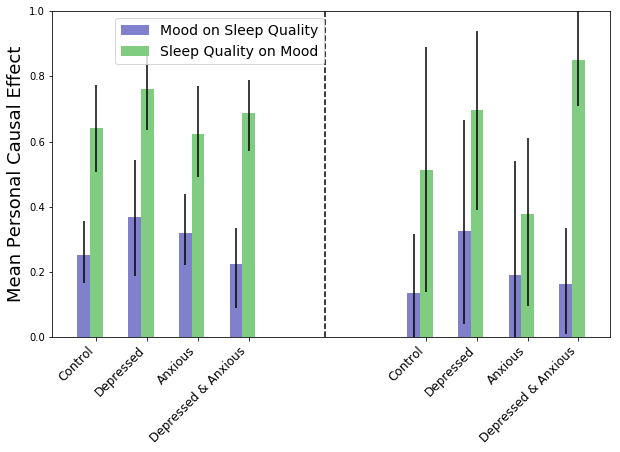

In [33]:
import matplotlib.pyplot as plt
%matplotlib inline

groups = ['Control', 'Depressed', 'Anxious', 'Depressed & Anxious']

plt.figure(figsize=(10,6))
yerrs = np.array([[np.mean(es_m2s_um_mean[:,3])-np.percentile(es_m2s_um_mean[:,3],2.5),\
                   np.mean(es_m2s_um_mean[:,2])-np.percentile(es_m2s_um_mean[:,2],2.5),\
                   np.mean(es_m2s_um_mean[:,1])-np.percentile(es_m2s_um_mean[:,1],2.5),\
                   np.mean(es_m2s_um_mean[:,0])-np.percentile(es_m2s_um_mean[:,0],2.5),\
                   np.mean(es_m2s_mean[:,3])-np.percentile(es_m2s_mean[:,3],2.5),\
                   np.mean(es_m2s_mean[:,2])-np.percentile(es_m2s_mean[:,2],2.5),\
                   np.mean(es_m2s_mean[:,1])-np.percentile(es_m2s_mean[:,1],2.5),\
                   np.mean(es_m2s_mean[:,0])-np.percentile(es_m2s_mean[:,0],2.5)],\
                  [-np.mean(es_m2s_um_mean[:,3])+np.percentile(es_m2s_um_mean[:,3],97.5),\
                   -np.mean(es_m2s_um_mean[:,2])+np.percentile(es_m2s_um_mean[:,2],97.5),\
                   -np.mean(es_m2s_um_mean[:,1])+np.percentile(es_m2s_um_mean[:,1],97.5),\
                   -np.mean(es_m2s_um_mean[:,0])+np.percentile(es_m2s_um_mean[:,0],97.5),\
                   -np.mean(es_m2s_mean[:,3])+np.percentile(es_m2s_mean[:,3],97.5),\
                   -np.mean(es_m2s_mean[:,2])+np.percentile(es_m2s_mean[:,2],97.5),\
                   -np.mean(es_m2s_mean[:,1])+np.percentile(es_m2s_mean[:,1],97.5),\
                   -np.mean(es_m2s_mean[:,0])+np.percentile(es_m2s_mean[:,0],97.5)]])
plt.bar([-4.75,-3.75,-2.75,-1.75,1.75,2.75,3.75,4.75],np.concatenate([np.mean(es_m2s_um_mean,axis=0),np.mean(es_m2s_mean,axis=0)],\
                                 axis=0).reshape([8,1]),yerr=yerrs, ecolor=(0,0,0),width=.25,color=(.5,.5,.8))
yerrs = np.array([[np.mean(es_s2m_um_mean[:,3])-np.percentile(es_s2m_um_mean[:,3],2.5),\
                   np.mean(es_s2m_um_mean[:,2])-np.percentile(es_s2m_um_mean[:,2],2.5),\
                   np.mean(es_s2m_um_mean[:,1])-np.percentile(es_s2m_um_mean[:,1],2.5),\
                   np.mean(es_s2m_um_mean[:,0])-np.percentile(es_s2m_um_mean[:,0],2.5),\
                   np.mean(es_s2m_mean[:,3])-np.percentile(es_s2m_mean[:,3],2.5),\
                   np.mean(es_s2m_mean[:,2])-np.percentile(es_s2m_mean[:,2],2.5),\
                   np.mean(es_s2m_mean[:,1])-np.percentile(es_s2m_mean[:,1],2.5),\
                   np.mean(es_s2m_mean[:,0])-np.percentile(es_s2m_mean[:,0],2.5)],\
                  [-np.mean(es_s2m_um_mean[:,3])+np.percentile(es_s2m_um_mean[:,3],97.5),\
                   -np.mean(es_s2m_um_mean[:,2])+np.percentile(es_s2m_um_mean[:,2],97.5),\
                   -np.mean(es_s2m_um_mean[:,1])+np.percentile(es_s2m_um_mean[:,1],97.5),\
                   -np.mean(es_s2m_um_mean[:,0])+np.percentile(es_s2m_um_mean[:,0],97.5),\
                   -np.mean(es_s2m_mean[:,3])+np.percentile(es_s2m_mean[:,3],97.5),\
                   -np.mean(es_s2m_mean[:,2])+np.percentile(es_s2m_mean[:,2],97.5),\
                   -np.mean(es_s2m_mean[:,1])+np.percentile(es_s2m_mean[:,1],97.5),\
                   -np.mean(es_s2m_mean[:,0])+np.percentile(es_s2m_mean[:,0],97.5)]])
plt.bar([-4.5,-3.5,-2.5,-1.5,2,3,4,5],np.concatenate([np.mean(es_s2m_um_mean,axis=0),np.mean(es_s2m_mean,axis=0)],\
                                 axis=0).reshape([8,1]),yerr=yerrs, ecolor=(0,0,0),width=.25,color=(.5,.8,.5))

# plt.text(-.2, .75, '***', fontsize=14)
# plt.text(1.8, .70, '***', fontsize=14)
# plt.text(2.8, .72, '***', fontsize=14)
# plt.text(3.8, .74, '***', fontsize=14)
# plt.text(4.8, .84, '***', fontsize=14)
a = plt.ylim([0,1])
# plt.xlim([-.5,5.5])
plt.xticks([-4.5,-3.5,-2.5,-1.5,2,3,4,5],groups*2, rotation=45, fontsize=12, ha='right');

plt.ylabel('Mean Personal Causal Effect',fontsize=18)
# plt.xlabel('lags 0 to T',fontsize=18)
plt.legend(['Mood on Sleep Quality','Sleep Quality on Mood'],loc='upper right',bbox_to_anchor=(.5, 1), fontsize=14);
plt.plot([0,0],[a[0],a[1]],'--',color=(0,0,0))

## Linear Output

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.figure(figsize=(6,5))
yerrs = np.array([[np.mean(es_m2s_um_mean)-np.percentile(es_m2s_um_mean,2.5),np.mean(es_m2s_mean[:,0])-np.percentile(es_m2s_mean[:,0],2.5),\
    np.mean(es_m2s_mean[:,1])-np.percentile(es_m2s_mean[:,1],2.5),np.mean(es_m2s_mean[:,2])-np.percentile(es_m2s_mean[:,2],2.5),\
    np.mean(es_m2s_mean[:,3])-np.percentile(es_m2s_mean[:,3],2.5)],\
    [np.percentile(es_m2s_um_mean,97.5)-np.mean(es_m2s_um_mean),np.percentile(es_m2s_mean[:,0],97.5)-np.mean(es_m2s_mean[:,0]),\
    np.percentile(es_m2s_mean[:,1],97.5)-np.mean(es_m2s_mean[:,1]),np.percentile(es_m2s_mean[:,2],97.5)-np.mean(es_m2s_mean[:,2]),\
    np.percentile(es_m2s_mean[:,3],97.5)-np.mean(es_m2s_mean[:,3])]])
plt.bar([-.25,1.75,2.75,3.75,4.75],np.concatenate([np.array([np.mean(es_m2s_um_mean)]),np.mean(es_m2s_mean,axis=0)],axis=0).reshape([5,1]),yerr=yerrs,\
    ecolor=(0,0,0),width=.25,color=(.5,.5,.8))
yerrs = np.array([[np.mean(es_s2m_um_mean)-np.percentile(es_s2m_um_mean,2.5),np.mean(es_s2m_mean[:,0])-np.percentile(es_s2m_mean[:,0],2.5),\
    np.mean(es_s2m_mean[:,1])-np.percentile(es_s2m_mean[:,1],2.5),np.mean(es_s2m_mean[:,2])-np.percentile(es_s2m_mean[:,2],2.5),\
    np.mean(es_s2m_mean[:,3])-np.percentile(es_s2m_mean[:,3],2.5)],\
    [np.percentile(es_s2m_um_mean,97.5)-np.mean(es_s2m_um_mean),np.percentile(es_s2m_mean[:,0],97.5)-np.mean(es_s2m_mean[:,0]),\
    np.percentile(es_s2m_mean[:,1],97.5)-np.mean(es_s2m_mean[:,1]),np.percentile(es_s2m_mean[:,2],97.5)-np.mean(es_s2m_mean[:,2]),\
    np.percentile(es_s2m_mean[:,3],97.5)-np.mean(es_s2m_mean[:,3])]])
plt.bar([0,2,3,4,5],np.concatenate([np.array([np.mean(es_s2m_um_mean)]),np.mean(es_s2m_mean,axis=0)],axis=0).reshape([5,1]),yerr=yerrs,\
    ecolor=(0,0,0),width=.25,color=(.5,.8,.5))
a = plt.ylim([-.1,1])
plt.xlim([-.5,5.5])
plt.xticks([0,2,3,4,5],['unmatched', 'T=0','T=1','T=2','T=3'],rotation=0);
plt.ylabel('Mean Personal Slope',fontsize=14)
plt.xlabel('lags 0 to T',fontsize=14)
plt.legend(['Mood on Sleep Quality','Sleep Quality on Mood'],loc='upper right',bbox_to_anchor=(1, 1), fontsize=10);
plt.plot([1,1],[a[0],a[1]],'--',color=(0,0,0))
plt.plot([-.5,5.5],[0,0],':',color=(0,0,0))

In [ ]:
es_m2s_mean.shape